### Libraries

In [1]:
import os
from google.cloud import texttospeech
from pydub import AudioSegment

import pandas as pd
from subprocess import check_output

# speech_v1p1beta1 is able to give word information
from google.cloud import speech_v1p1beta1 as speech
from google.cloud.speech_v1p1beta1 import enums
from google.cloud.speech_v1p1beta1 import types

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from credential_path import credential_path
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path

### Generate speech

Google Text-to-Speech docs: https://cloud.google.com/text-to-speech/docs/

SSML docs: https://cloud.google.com/text-to-speech/docs/ssml

In [3]:
def text_to_speech(ssml, file):
    client = texttospeech.TextToSpeechClient()

    synthesis_input = texttospeech.types.SynthesisInput(ssml=ssml)

    voice = texttospeech.types.VoiceSelectionParams(
        language_code='en-US',
        ssml_gender=texttospeech.enums.SsmlVoiceGender.NEUTRAL)

    audio_config = texttospeech.types.AudioConfig(
        audio_encoding=texttospeech.enums.AudioEncoding.LINEAR16)

    response = client.synthesize_speech(synthesis_input, voice, audio_config)

    with open(file, 'wb') as out:
        out.write(response.audio_content)

In [4]:
text_to_speech("""
<speak>
    The quick brown fox jumps over the lazy dog.
</speak>
""", 'true.wav')
true_audio = AudioSegment.from_wav('true.wav')
true_audio

Generate user audio, same as true except the word ```fox``` is slowed down.

In [5]:
text_to_speech("""
<speak>
    The quick brown <prosody rate="slow">fox</prosody> jumps over the lazy dog.
</speak>
""", 'user.wav')
user_audio = AudioSegment.from_mp3('user.wav')
user_audio

### Evaluate speech

Google Speech-to-Text docs: https://cloud.google.com/speech-to-text/docs/

In [6]:
def speech_to_text(speech_file):
    
    client = speech.SpeechClient()

    with open(speech_file, 'rb') as audio_file:
        content = audio_file.read()

    audio = types.RecognitionAudio(content=content)
    
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=24000,
        language_code='en-US',
        enable_word_confidence=True,
        enable_word_time_offsets=True,
    )

    response = client.recognize(config, audio)
    
    return response

In [7]:
true_response = speech_to_text('true.wav')
true_response

results {
  alternatives {
    transcript: "the quick brown fox jumps over the lazy dog"
    confidence: 0.9799774885177612
    words {
      start_time {
      }
      end_time {
        nanos: 200000000
      }
      word: "the"
      confidence: 0.9876290559768677
    }
    words {
      start_time {
        nanos: 200000000
      }
      end_time {
        nanos: 500000000
      }
      word: "quick"
      confidence: 0.9876290559768677
    }
    words {
      start_time {
        nanos: 500000000
      }
      end_time {
        nanos: 500000000
      }
      word: "brown"
      confidence: 0.9876290559768677
    }
    words {
      start_time {
        nanos: 500000000
      }
      end_time {
        nanos: 900000000
      }
      word: "fox"
      confidence: 0.9876290559768677
    }
    words {
      start_time {
        nanos: 900000000
      }
      end_time {
        seconds: 1
        nanos: 600000000
      }
      word: "jumps"
      confidence: 0.9111142754554749
    }
 

In [8]:
user_response = speech_to_text('user.wav')

Convert Google response to more readable dataframe:

In [9]:
def response_to_df(response):
    words = []
    for word in response.results[0].alternatives[0].words:
        start = word.start_time.seconds*10**3+10**-6*word.start_time.nanos
        end = word.end_time.seconds*10**3+10**-6*word.end_time.nanos
        words.append({
            'word': word.word,
            'confidence': word.confidence,
            'start': start,
            'end': end,
            'dif': end-start,
        })
    return pd.DataFrame(words)

In [10]:
true_df = response_to_df(true_response)
true_df['silence'] = true_df.start-true_df.end.shift(1)
true_df

,confidence,dif,end,start,word,silence
0,0.987629,200.0,200.0,0.0,the,NaN
1,0.987629,300.0,500.0,200.0,quick,0.0
2,0.987629,0.0,500.0,500.0,brown,0.0
3,0.987629,400.0,900.0,500.0,fox,0.0
4,0.911114,700.0,1600.0,900.0,jumps,0.0
5,0.987629,100.0,1700.0,1600.0,over,0.0
6,0.987629,100.0,1800.0,1700.0,the,0.0
7,0.987629,200.0,2000.0,1800.0,lazy,0.0
8,0.987629,300.0,2300.0,2000.0,dog,0.0


In [11]:
user_df = response_to_df(user_response)
user_df['silence'] = user_df.start-user_df.end.shift(1)
user_df

,confidence,dif,end,start,word,silence
0,0.987629,200.0,200.0,0.0,the,NaN
1,0.987629,300.0,500.0,200.0,quick,0.0
2,0.987629,0.0,500.0,500.0,brown,0.0
3,0.987629,700.0,1200.0,500.0,fox,0.0
4,0.844559,1300.0,2500.0,1200.0,jumps,0.0
5,0.926127,100.0,2600.0,2500.0,over,0.0
6,0.987629,100.0,2700.0,2600.0,the,0.0
7,0.987629,200.0,2900.0,2700.0,lazy,0.0
8,0.987629,400.0,3300.0,2900.0,dog,0.0


### Compare timing user to correct timing

Plot adjusted from https://stackoverflow.com/questions/21397549/stack-bar-plot-in-matplotlib-and-add-label-to-each-section-and-suggestions

Darker green indicates better timing. Although the word ```fox``` is slowed down, somehow Google speech-to-text finds ```jumps``` is slowed down.

In [12]:
def plot_timing(true_df, user_df):
    data = np.array([user_df.dif.values, true_df.dif.values]).T
    percentages = np.array([user_df.word.values, true_df.word.values])
    y_pos = np.arange(2)

    fig = plt.figure(figsize=(14, 3))
    ax = fig.add_subplot(111)

    patch_handles = []
    left = np.zeros(2) # left alignment of data starts at zero
    for i, d in enumerate(data):
        # score calculation, lower is better
        if d[0] == 0:
            score = 0
        else:
            score = abs(d[1]-d[0])/d[0]
        penalty = 1.5
        color = (score*penalty, 1, score*penalty)
        patch_handles.append(ax.barh(y_pos, d, 
          color=color, align='center', 
          left=left))
        # accumulate the left-hand offsets
        left += d

    # go through all of the bar segments and annotate
    for j in range(len(patch_handles)):
        for i, patch in enumerate(patch_handles[j].get_children()):
            if i == 1:
                patch.set_facecolor((0, 1, 0))
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            ax.text(x,y, percentages[i,j], ha='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(('User', 'Correct'))
    ax.set_xlabel('Time (milliseconds)');

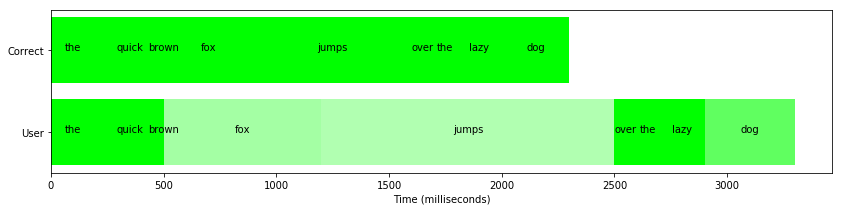

In [13]:
plot_timing(true_df, user_df)

### Mozilla Deepspeech text to speech

https://github.com/mozilla/DeepSpeech

DeepSpeech: v0.5.0-alpha.4-14-g26af3b2

In [14]:
def deepspeech(file):
    out = check_output(['deepspeech',
     '--model',
     'models/output_graph.pbmm',
     '--alphabet',
     'models/alphabet.txt',
     '--lm',
     'models/lm.binary',
     '--trie',
     'models/trie',
     '--audio',
     file,
     '-e'])
    words = pd.DataFrame([
        dict(zip(['word', 'start', 'dif'], line.split(','))) 
        for line in str(out, 'utf-8').strip().split('\n')])
    words.start = words.start.astype(float)
    words.dif = words.dif.astype(float)
    words['end'] = words.start+words.dif
    return pd.DataFrame(words, columns=['word', 'start', 'end', 'dif'])

In [15]:
true_ds = deepspeech('true.wav')
true_ds['silence'] = true_ds.start-true_ds.end.shift(1)
true_ds

,word,start,end,dif,silence
0,the,0.14,0.30,0.16,NaN
1,quick,0.34,0.58,0.24,0.04
2,brown,0.66,0.96,0.30,0.08
3,fox,1.02,1.34,0.32,0.06
4,jumps,1.38,1.60,0.22,0.04
5,over,1.66,1.84,0.18,0.06
6,the,1.88,1.98,0.10,0.04
7,lazy,2.02,2.36,0.34,0.04
8,dog,2.46,2.64,0.18,0.10


In [16]:
user_ds = deepspeech('user.wav')
user_ds['silence'] = user_ds.start-user_ds.end.shift(1)
user_ds

,word,start,end,dif,silence
0,the,0.14,0.28,0.14,NaN
1,quick,0.32,0.56,0.24,0.04
2,brown,0.62,1.30,0.68,0.06
3,fox,1.40,2.22,0.82,0.10
4,jumps,2.28,2.48,0.20,0.06
5,over,2.56,2.74,0.18,0.08
6,the,2.78,2.90,0.12,0.04
7,lazy,2.94,3.28,0.34,0.04
8,dog,3.38,3.54,0.16,0.10


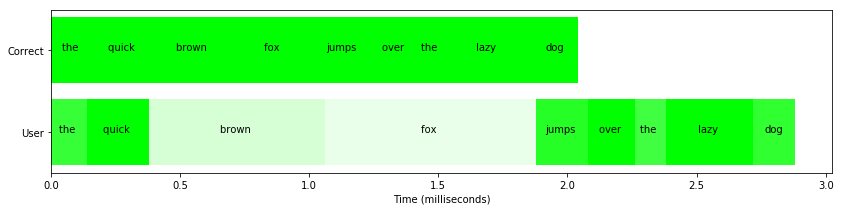

In [17]:
plot_timing(true_ds, user_ds)